<a href="https://colab.research.google.com/github/whuang61/-Amazon_Vine_Analysis/blob/main/outlier_detection_fraud_data_python3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Please ***DO NOT*** edit/run this notebook directly, otherwise others will have trouble rerunning the cells!




please click File -> save a copy in your own drive or download instead, then play with your copy! Thanks!

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from sklearn.ensemble import IsolationForest
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


# Data Import

In [ ]:
# method 1: save the data in https://drive.google.com/drive/folders/1h7dB3SLd6HYJAisALnMax28r1idDS-N6 to your own google drive: 
# create a folder: fraudData in https://drive.google.com/drive/u/0/my-drive (the home/root folder of gDrive is: My Drive), put the file: creditcard.csv in folder fraudData
# then follow Garima Jain in https://stackoverflow.com/questions/48340341/read-csv-to-dataframe-in-google-colab

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/fraudData"

creditcard.csv	imbalancedFraudDF.csv  IpAddress_to_Country.csv


In [ ]:
creditcardDF = pd.read_csv('drive/My Drive/fraudData/creditcard.csv') #much faster once saved in drive
creditcardDF.head()#all numerical

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#method 2a, very slow, not suggested
#download the creditcard.csv to your local machine, then upload it:

from google.colab import files
uploaded = files.upload()
# It will prompt you to select a file. (may need to rerun this cell to enable this). Click on “Choose Files” then select and upload the file. Wait for the file to be 100% uploaded. 
# You should see the name of the file once Colab has uploaded it. this may take up to 15 mins

Saving creditcard.csv to creditcard.csv


In [ ]:
##method 2b, Finally, type in the following code to import it into a dataframe (make sure the filename matches the name of the uploaded file).


creditcardDF = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

creditcardDF.head()

In [ ]:
#Distribution of the label column
creditcardDF['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
492 / (284315  + 492) #<0.2 percent

0.001727485630620034

In [ ]:
creditcardDF.shape

(284807, 31)

In [ ]:
creditcardDF.isna().sum()#null checking

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

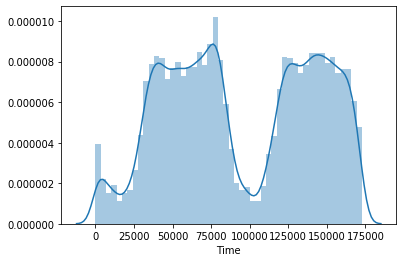

In [ ]:


sns.distplot(creditcardDF['Time'])

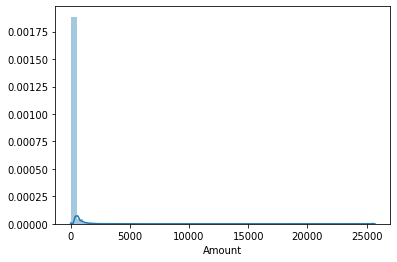

In [ ]:

sns.distplot(creditcardDF['Amount'])

In [ ]:
creditcardDF['Amount'] = np.log(creditcardDF['Amount'] + 1)

creditcardDF['Time'] = np.log(creditcardDF['Time'] + 1)

normal = creditcardDF[creditcardDF['Class'] == 0]
anomaly = creditcardDF[creditcardDF['Class'] == 1]

train, small_normal = train_test_split(normal, test_size=0.2, random_state=0)
normal_valid, normal_test = train_test_split(small_normal, test_size=0.5, random_state=0)#2000 : 2000 good hd
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)#10 : 10 bad hd

validation = pd.concat([normal_valid, anomaly_valid])#include both good and bad, cross validation data in our text
test = pd.concat([normal_test, anomaly_test])#include both good and bad


print(validation.shape)
print(test.shape)

train = train.drop(columns = ['Class']).reset_index(drop= True)#no need of label in train data, drop it
print(train.shape)

(28677, 31)
(28678, 31)
(227452, 30)


In [ ]:
featureNames = list(train.columns.values)#feature names only, no label
valFeatures = validation[featureNames].reset_index(drop= True)#feature df only, no label
testFeatures = test[featureNames].reset_index(drop= True)#feature df only, no label

valLabel = validation['Class']#label df only
testLabel = test['Class']#label df only



In [ ]:
valFeatures.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11.827043,-0.248023,1.259502,-0.993999,-1.587788,1.913462,-0.630270,1.958852,-0.659274,0.002373,0.718353,0.474332,0.297023,-0.025971,0.256813,-0.730278,-0.479395,-1.145347,0.234891,0.351396,0.396605,0.089915,0.896611,-0.367547,0.143515,-0.177558,0.025269,0.271419,-0.066416,0.920283
1,10.809566,-1.614505,-0.970137,1.730517,-1.715497,-0.869271,-0.171355,1.216768,-0.031314,0.992762,-2.191051,-1.019348,0.600947,0.821185,-0.477250,0.612733,-0.092783,-0.664174,0.643702,-0.047904,0.831753,0.408654,0.630537,0.382848,-0.110627,0.906539,-0.618206,-0.026364,0.104561,5.874931
2,11.340380,1.106176,0.148096,0.424489,1.282916,-0.080275,0.146526,-0.007108,0.114953,-0.004731,0.033642,1.200830,1.342878,0.018898,0.217944,-0.819673,-0.536572,-0.000444,-0.509860,-0.081917,-0.148073,-0.042488,0.071593,-0.085294,0.032780,0.637894,-0.331179,0.036130,0.007639,2.866193
3,11.321208,-1.791995,1.102738,0.324217,1.082267,-0.303348,-1.050303,0.066270,0.613586,-0.720545,-0.232754,-0.741686,0.317251,0.404740,0.810007,0.990986,-0.069383,0.096501,0.143086,0.447363,-0.285331,0.151935,0.514245,0.290932,0.403345,-0.064118,-0.318054,0.021940,0.013401,3.432373
4,11.956784,1.924286,0.324362,-0.734639,3.370481,0.783552,1.224944,-0.298881,0.291717,-0.790152,1.592072,-0.561561,-0.101690,-0.249445,0.233490,-1.160360,1.566431,-1.480919,0.594003,-0.903739,-0.227395,-0.022543,-0.115448,0.143200,-0.357497,-0.109288,-0.105516,-0.025440,-0.050761,2.572612


In [ ]:
validation['Class'].value_counts()

0    28431
1      246
Name: Class, dtype: int64

In [ ]:
test['Class'].value_counts()




0    28432
1      246
Name: Class, dtype: int64

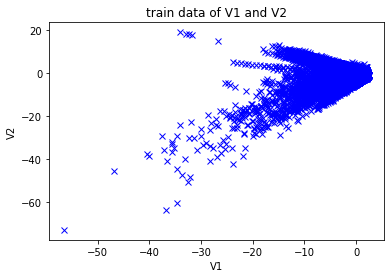

In [ ]:
plt.figure()
plt.title("train data of V1 and V2")#may contain outliers
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx")
plt.show()




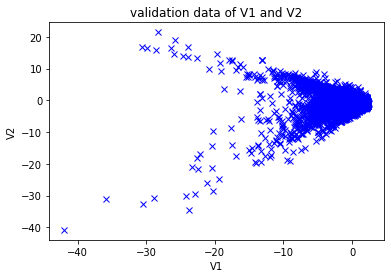

In [ ]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

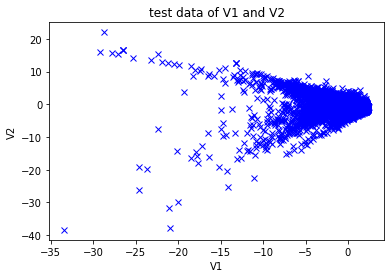

In [ ]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

In [ ]:
# np.arange(1, 20, 2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

In [ ]:
# def read_dataset(filePath, delimiter=','):
#     return genfromtxt(filePath, delimiter=delimiter)

#find parameter for each col/feature in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


In [ ]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
#Return evenly spaced numbers over a specified interval.
np.linspace(1, 21,10, endpoint = False)

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

In [ ]:
#step 1: model training
mu, sigma = estimateGaussian(train)

#generate The probability density function/curve/surface/model for multivariate_normal given mean and cov 
#allow_singular: Whether to allow a singular covariance matrix. (Default: False); multivariate_normal needs inverse of cov
model = multivariate_normal(mean=mu, cov=sigma, allow_singular = True)#surface hat p(x)


In [ ]:

pdfVal = model.pdf(valFeatures)
print(max(pdfVal))#too small, can not differentiate
print(min(pdfVal))

p_val = model.logpdf(valFeatures)#Log of the pdf first, then apply to features, to change the magnitude of prob
print(max(p_val))#
print(min(p_val))

3.936022689247968e-12
0.0
-26.26085037221045
-7554.270217704667


In [ ]:
p = model.logpdf(train)
print(p.shape)
print((p_val.shape))

# print(p)


(227452,)
(28677,)


In [ ]:
print(p_val)
print(p_val < -500)

[  -31.28574735   -34.94205051   -27.79402451 ... -5175.93656039
 -4545.5057626    -29.7152192 ]
[False False False ...  True  True False]


In [ ]:
[[1],[2],[3]]

ravel ->
[1,2,3]

In [ ]:

#step 2
scores = []
p_val = model.logpdf(valFeatures)#Log of the pdf

# thresholds = np.linspace(-1000, -10,150)
thresholds = np.linspace(min(p_val), max(p_val),200)#generate all candidate threshold, epsilon

#step 2:  find optimal threshold: bestThreshold
for threshold in thresholds:
  y_pred = (p_val < threshold).astype(int)# list of 0 and 1
  #calculate recall, precision and f1 for each (truth, pred) pair, corresponding to that threshold
  scores.append([recall_score(valLabel, y_pred),
                 precision_score(valLabel, y_pred),
                 f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)
maxIndex = scores[...,2].ravel().argmax()#maxIndex of the 3rd column (f1_score) #193, #.ravel return a flattened array
bestThreshold = thresholds[maxIndex]
print(scores.shape)#each row is a pair of (recall, precision, f1) corresponding to a threshold

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(200, 3)


In [ ]:
print(scores)

[[0.         0.         0.        ]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01

In [ ]:
print(maxIndex)
print(bestThreshold)

193
-253.2360071762041


In [ ]:
np.mean(train.iloc[:,1])

0.005246755420062154

In [ ]:
mu[1]

0.005246755420062154

In [ ]:
print(mu)
# print(sigma)




Time      11.252384
V1         0.005247
V2        -0.005416
V3         0.010293
V4        -0.008144
V5         0.004281
V6         0.001813
V7         0.010354
V8        -0.001103
V9         0.006351
V10        0.009573
V11       -0.007736
V12        0.009943
V13        0.001084
V14        0.010816
V15        0.001082
V16        0.007216
V17        0.012364
V18        0.003412
V19       -0.001811
V20       -0.001092
V21       -0.001302
V22       -0.000354
V23        0.000209
V24        0.000288
V25        0.000375
V26        0.000457
V27       -0.000509
V28       -0.000119
Amount     3.152259
dtype: float64


In [ ]:
#performance on test data
#step 3: prediction on test data
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold

f1_score(testLabel, y_pred_test, average = "binary")

0.7401574803149606

In [ ]:
y_pred_test

array([False, False, False, ...,  True, False,  True])

In [ ]:
#index of predicted outliers in test data
predoutliersTest = np.asarray(np.where(y_pred_test))

len(predoutliersTest[0])

262

In [ ]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8267,  8452,  8611,  8677,
         8936,  8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657,
        11224, 12205, 13539, 13935, 14050, 14573, 14579, 14802, 14869,
        15740, 16061, 16888, 17322, 17663, 19352, 19902, 20680, 20800,
        21748, 22366, 22552, 22859, 23217, 23456, 23742, 24639, 24819,
        25654, 25678, 26035, 27282, 27293, 27314, 27587, 27723, 28117,
        28178, 28396, 28432, 28433, 28434, 28435, 28436, 28437, 28438,
        28440, 28443, 28444, 28445, 28446, 28447, 28449, 28450, 28453,
        28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462,
        28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471,
        28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28484,
        28486, 28487, 28490, 28492, 28493, 28494, 28496, 28497, 28498,
      

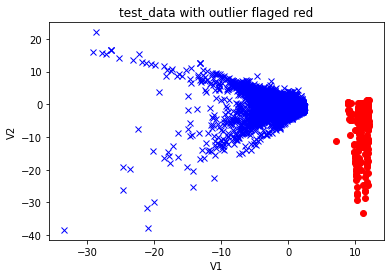

In [ ]:
#outliers identified on test data feature column V1 V2
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(testFeatures.iloc[:, 1],testFeatures.iloc[:,2],"bx")#plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")#re-plot the outliers as red dots
plt.show()

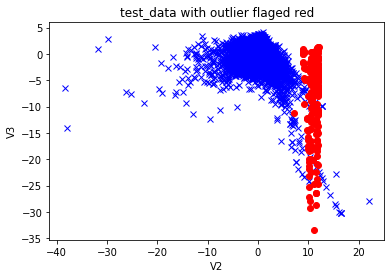

In [ ]:
#outliers identified on test data feature column V2 V3
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V2")
plt.ylabel("V3")
plt.plot(testFeatures.iloc[:, 2],testFeatures.iloc[:,3],"bx")
plt.plot(testFeatures.iloc[predoutliersTest[0],1],testFeatures.iloc[predoutliersTest[0],2],"ro")
plt.show()

In [ ]:


# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_test_pred_raw)))#correction: y_pred_test instead of y_test_pred_raw
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0



accuracy_score is: : 0.9953971685612665
roc_auc_score is: : 0.03898289914947546
f1_score is: : 0.7401574803149606
confusion_matrix is: 
        pred_0  pred_1
true_0   28358      74
true_1      58     188
recall = 0.7642276422764228
precision = 0.7175572519083969


In [ ]:
#note we can apply supervised learning on this data too, but performance may be different, 
#can try use the output prob as an additional input feature of the supervised learning model, and see if it improved the model perf

In [ ]:
# Number of estimators: n_estimators refers to the number of base estimators or trees in the ensemble, i.e. the number of trees that will get built in the forest. 
# This is an integer parameter and is optional. The default value is 100.

# Max samples: max_samples is the number of samples to be drawn to train each base estimator. If max_samples is more than the number of samples provided, 
# all samples will be used for all trees. The default value of max_samples is 'auto'. If 'auto', then max_samples=min(256, n_samples)

# Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. 
# This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. 
# If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.

# Max features: All the base estimators are not trained with all the features available in the dataset. It is the number of features to 
# draw from the total features to train each base estimator or tree.The default value of max features is one.

IFModel = IsolationForest(random_state=0, contamination = 0.01, n_estimators = 200, max_features = 2).fit(train)
IFModel

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=2, max_samples='auto', n_estimators=200,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [ ]:
# convert 1/-1 to 0/1 for f1 calculation
def convert(x):
  if x == 1:
    return 0
  else:
    return 1
pred = IFModel.predict(testFeatures) #1 for inliers, -1 for outliers.
pred2 = list(map(convert, pred))
# pred2
import collections

counter=collections.Counter(pred2)
print(counter)#

f1_score(testLabel, pred2, average = "binary")#0.48 when added parameters

Counter({0: 28288, 1: 390})


0.48113207547169806